In [1]:
import pickle
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm.notebook import trange

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

from function.conserve import Entropy
from function.seqfilter import SeqFilter
from function.conserve import ConservePeraa
from function.utilities import get_taxid_dict
from function.utilities import get_protein_name
from function.utilities import get_uniprot_rawdata
from function.utilities import find_human_sequence

# param

In [2]:
#####CHANGE HERE#####
uniprot_id = 'Q13148'
algorithm = 'VSL2'
#####CHANGE HERE#####

In [3]:
tax_ids = [7711,7742,32523,40674]

input_path = Path("./output/extre_filtered_fasta")

disorder_filter_length = 40
order_filter_length = 10

conserve_peraa_sort = ['A','C','D','E','G','H','I','K','L','M','N','P','Q','R','S','T','V','F','W','Y']

# load uniprot and PONDR identified data

In [4]:
human_uniprot_path = Path('./rawdata/human_uniprot.tab')
human_df = get_uniprot_rawdata(human_uniprot_path)

pondr_disorder_ident_path = Path("./output/pondr_disorder_ident")
od_human_df = pd.read_pickle(pondr_disorder_ident_path/'{}_od_human_df.pkl'.format(algorithm))

# conservation level

In [5]:
def get_only_human_score(score,fasta_path):
    '''
    只拿human有的分數，gap都不拿
    
    score: entropy.alied_entropy做的分數
    fasta_path: path
    '''
    nogap_score = []
    nogap = np.array(list(find_human_sequence(fasta_path)['sequence'])) != '-'
    nogap_index = np.where(nogap)[0].tolist()
    for index in nogap_index:
        nogap_score.append(score[index])    
    return nogap_score

In [6]:
def get_conserve_score_odregion(tax_id,
                                uniprot_id):

    #read fasta
    fasta_path = input_path / str(tax_id) /"{}.fasta".format(uniprot_id)
    
    #get score
    conserve_score = entropy.alied_entropy(fasta_path)
    
    #only_nogap_index
    conserve_score = get_only_human_score(conserve_score,fasta_path)
    
    #get order/disorder region
    od_ident = od_human_df[od_human_df['uniprot_id'] == uniprot_id]['od_ident'].values[0] #拿到od序列
    od_ident = seqfilter.length_filter_by_od_ident(od_ident,disorder_filter_length,order_filter_length) #篩長度
    
    #score and od_ident length err exception
    #因為oma資料庫的關係，名字一樣，長度會不一樣
    if len(conserve_score) != len(od_ident):
        print("{} ENTROPY LENGTH IS NOT EQUAL WITH OD_IODENT".format(uniprot_id))
        raise Exception("error")
    
    #human_sequence, remove gap
    human_sequence = find_human_sequence(fasta_path)['sequence']
    human_sequence = human_sequence.replace('-','')
    
    #get region after remove gap
    region = seqfilter.get_od_index(od_ident)
    
    
    #get info
    taxonomy = get_taxid_dict()[tax_id]
    gene_name = get_protein_name(uniprot_id,human_df)['gene_name']
    
    return {"uniprot_id":uniprot_id,
            "gene_name":gene_name,
            "taxonomy":taxonomy,
            "score":conserve_score,
            "od_ident":od_ident,
            "human_sequence":human_sequence,
            "region":region}

In [7]:
entropy = Entropy()
seqfilter = SeqFilter()

In [8]:
conserve_list = []

t = trange(len(tax_ids), leave=True)
for i in t:
    t.set_description(str(tax_ids[i]))
    t.refresh()
    
    conserve = get_conserve_score_odregion(tax_id=tax_ids[i],
                                           uniprot_id=uniprot_id)
    conserve_list.append(conserve)

  0%|          | 0/4 [00:00<?, ?it/s]

## conservation level output

In [9]:
conserve_list

[{'uniprot_id': 'Q13148',
  'gene_name': 'TARDBP',
  'taxonomy': 'chordata',
  'score': [0.753,
   0.783,
   0.755,
   1.0,
   0.949,
   0.979,
   0.979,
   0.829,
   0.958,
   0.865,
   1.0,
   1.0,
   0.824,
   1.0,
   1.0,
   0.835,
   1.0,
   0.979,
   1.0,
   0.958,
   1.0,
   0.979,
   0.979,
   1.0,
   1.0,
   0.958,
   0.958,
   1.0,
   1.0,
   0.979,
   0.979,
   0.809,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   0.963,
   0.858,
   1.0,
   0.852,
   0.979,
   0.963,
   0.901,
   0.979,
   0.963,
   1.0,
   1.0,
   1.0,
   0.979,
   0.979,
   0.979,
   0.979,
   0.963,
   1.0,
   0.872,
   1.0,
   0.979,
   0.926,
   1.0,
   0.788,
   0.757,
   0.937,
   1.0,
   0.979,
   0.979,
   0.823,
   0.921,
   0.963,
   0.937,
   1.0,
   0.963,
   0.963,
   1.0,
   1.0,
   0.884,
   1.0,
   0.979,
   1.0,
   1.0,
   0.979,
   0.895,
   0.958,
   0.756,
   0.958,
   0.937,
   0.907,
   0.979,
   0.925,
   0.942,
   0.958,
   0.74,
   0.958,
   0.946,
   0.

# conservation peraa

In [10]:
conserveperaa = ConservePeraa()

In [13]:
def data_make_array(uniprot_id):
    data_array = np.zeros((2,2,20,len(tax_ids)))
    #2(content/conserve), 2(order/disorder), 20(A, C, D, E), 4(7711, 7742, 32523...)

    for tax_index,tax_id in enumerate(tax_ids):   
        
        #read fasta
        fasta_path = input_path / str(tax_id) /"{}.fasta".format(uniprot_id)
        
        #get order/disorder region
        od_ident = od_human_df[od_human_df['uniprot_id'] == uniprot_id]['od_ident'].values[0] #拿到od序列
        print(len(od_ident))
        od_ident = seqfilter.length_filter_by_od_ident(od_ident,disorder_filter_length,order_filter_length) #篩長度
        
        od_ident = seqfilter.od_add_alignment(fasta_path,od_ident) #alied fasta
        
        #算conserve值，跟算aa的數量
        info_dict = conserveperaa.get_aa_info(fasta_path,od_ident)
        order_conserve,order_content = info_dict['conserve']['order'],info_dict['content']['order']
        disorder_conserve,disorder_content = info_dict['conserve']['disorder'],info_dict['content']['disorder']

        #塞入array
        for aa_index,element in enumerate(conserve_peraa_sort):
            data_array[0][0][aa_index][tax_index] = order_content[element]
            data_array[0][1][aa_index][tax_index] = disorder_content[element]
            data_array[1][0][aa_index][tax_index] = order_conserve[element]
            data_array[1][1][aa_index][tax_index] = disorder_conserve[element]
    return data_array                                                           

In [14]:
data_array = data_make_array(uniprot_id)

414
414
ooooooooooooooooooxxxxxxxxxxxxxoxxxxxxxxxx000000000000000000000000000000000000000000000000000000000xxoooooooooooxxxxxxxxxxxxxxxxxx00000000000000000000000000000000000000xxxxxxx00000000000000000000000000000000xxxxxxoooxxxxxxxxxxxxxxxxxxxxxxxxxx000000000000000000000000000000000000000000000000000001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111
551
------------------MSEYIRVTEDEND-EPIEIPSEDDGTVLLSTVTAQFPGACGLRYRNPVSQCMRGVRLVEGILHAPD--AGWGNLVYVVNYPKD-----------NKRKMDETDASSAVKVKRAVQKTSDLIVLGLPWKTTEQDLKEYFSTFGEVLMVQVKKDLKTGHSKGFGFVRFTEYETQVKVMSQRHMIDGRWCDCKLPNSK---QSQDEPLRSRKVFVGRCTEDMTEDELREFFSQYGDVMDVFIPKPFRAFAFVTFADDQ---IAQSLCGEDLIIKGISVHISNAEPKHNSNRQL-ERSGRFGGNPGGFGNQGGFGNSR-------GGGA-GLGNN-----QGSNMGG---------GMNFGAFSINPAMMAAAQAALQSSWGMM--GMLASQQNQS-GPSGNNQNQ-GNMQR-EPNQAFGSG

# plot

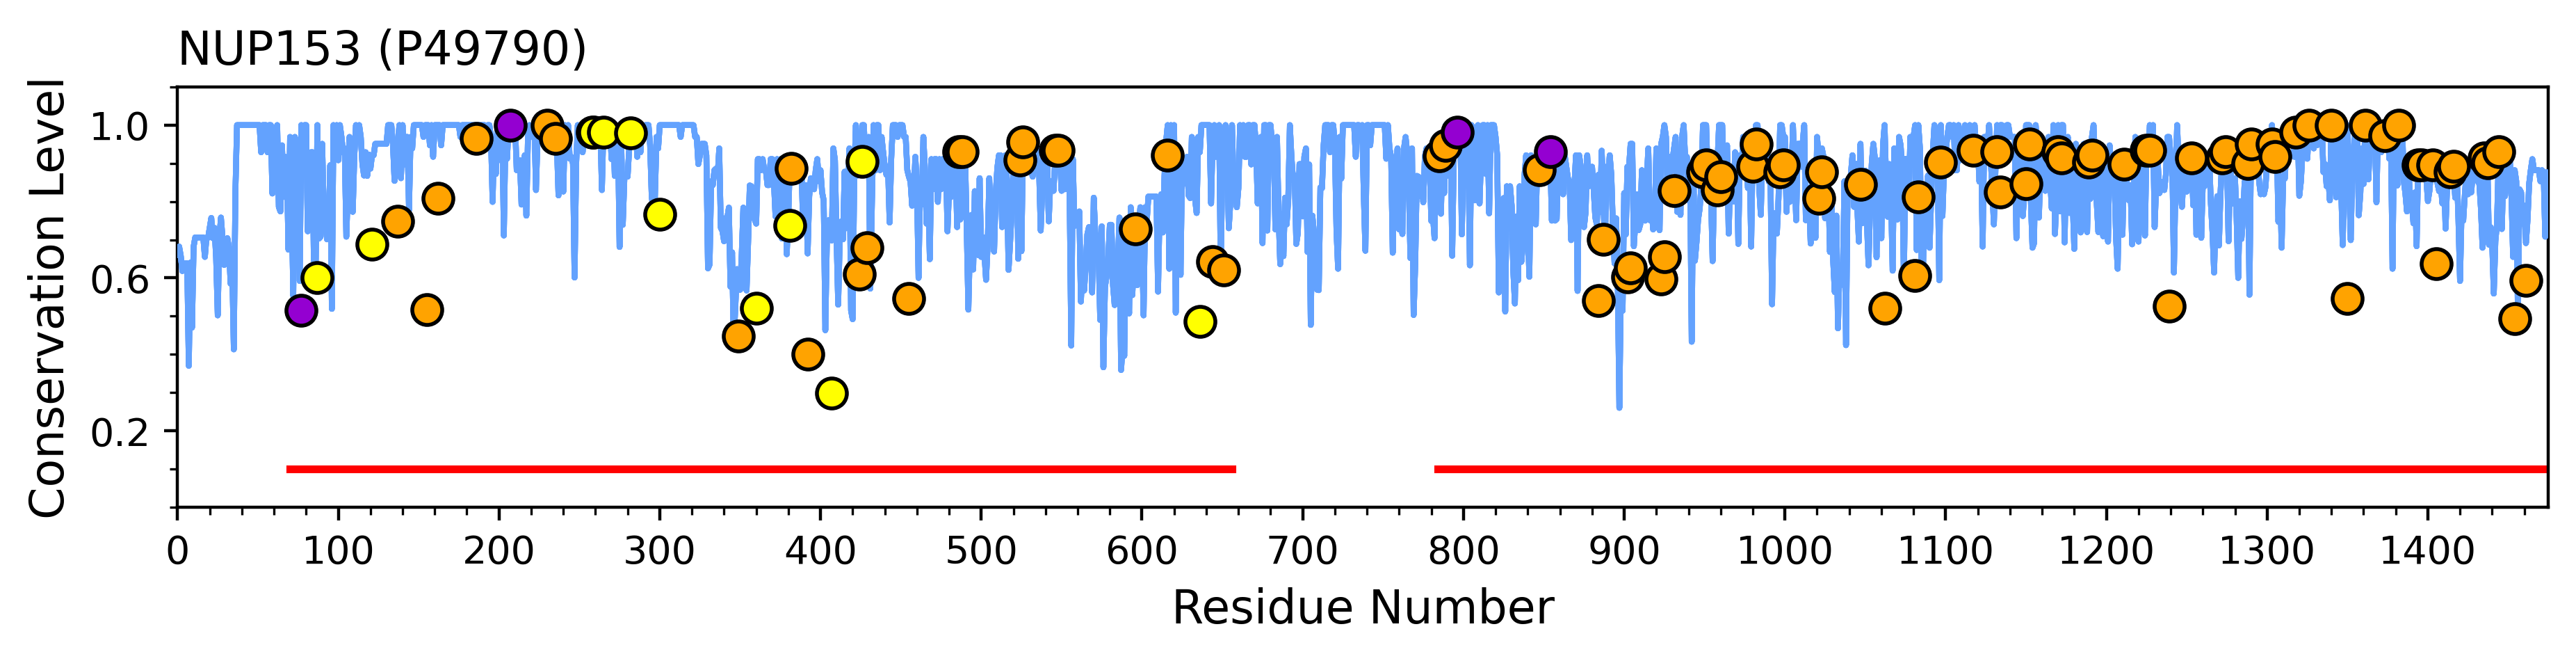

In [29]:
f, (a0) = plt.subplots(1, 1,sharex=True,sharey=True,figsize=(11,2),dpi=400)

for i in conserve_list:
    
    #line
    if i['taxonomy'] == 'chordata':
        a0.plot(i['score'],color="#335079",zorder=100,linewidth=1.5)
    elif i['taxonomy'] == 'vertebrata':
        a0.plot(i['score'],color="#b5b5b5",zorder=75,linewidth=0.5)
    elif i['taxonomy'] == 'tetrapoda':
        a0.plot(i['score'],color="#b5b5b5",zorder=50,linewidth=0.5)
    elif i['taxonomy'] == 'mammalia':
        a0.plot(i['score'],color="#63a2fe",zorder=25,linewidth=1.5)
    
    a0.set_xlim(0,len(i['score']))
    a0.xaxis.set_major_locator(MultipleLocator(100))
    a0.xaxis.set_minor_locator(MultipleLocator(20))
    
    
    a0.yaxis.set_major_locator(MultipleLocator(0.4))
    a0.yaxis.set_minor_locator(MultipleLocator(0.1))
    a0.set_yticks(np.arange(0.2,1.2,0.4))
    a0.set_ylim(0,1.1)
    
    
    title = "{} ({})".format(data_list[0]['gene_name'],data_list[0]['uniprot_id'],fontsize=12)
    a0.set_title(title,loc='left')
    a0.set_xlabel("Residue Number",fontsize=12)
    a0.set_ylabel("Conservation Level",fontsize=12)
    


for region in data_list[0]['region']['disorder_region']:
    start = region['start']
    start = start / len(data_list[0]['human_sequence'])
    end = region['end']
    end = end / len(data_list[0]['human_sequence'])
    
    a0.axhline(0.1, start, end, color='#ff0000',linewidth=2)    

#WYF point
for index,(od,aa,score) in enumerate(zip(data_list[0]['od_ident'],data_list[0]['human_sequence'],data_list[0]['score'])):
    if od == '1':
        if aa == 'Y':
            a0.scatter(index,score,s=60,color='#ffff00',edgecolors='black',zorder=200)
        elif aa == 'F':
            a0.scatter(index,score,s=60,color='#ffa300',edgecolors='black',zorder=200)
        elif aa == 'W':
            a0.scatter(index,score,s=60,color='#9400d1',edgecolors='black',zorder=200)